## Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#from fastai import *
#from fastai.vision import *

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.io import wavfile as wav
# from scipy.fftpack import fft
import numpy as np
import os
#import librosa
from mutagen.aac import AAC
from pathlib import Path
from tqdm import tqdm
import glob
import IPython
import librosa
import gc

## Basic Data sanity check on audio files - Every file has 10s of audio?

If audio files are not in wav format, then: for f in *.m4a; do avconv -i "$f" "${f/%m4a/wav}"; done

In [4]:
!pwd

/home/sramirez/git/FeuerFreiKiller/notebooks


In [5]:
audio_data_path = '../data/processed/nature_sounds_dataset/wav/'
image_data_path = '../data/google_nature_spectogram/'

In [6]:
all_files = glob.glob(audio_data_path + "/*.wav")

IPython.display.Audio(all_files[0])

In [7]:
all_files[0]

'../data/processed/nature_sounds_dataset/wav/vFQZIynVjo0.wav'

In [8]:
checdf = pd.DataFrame(columns=['yid', 'size'])
for i in tqdm(glob.glob("../data/processed/nature_sounds_dataset/*.aac")):
    try:
        audio = AAC(i)
        checdf = checdf.append({'yid':os.path.basename(i), 'size': audio.info.length}, ignore_index=True)
    except:
        print("Error")

 29%|██▉       | 1275/4394 [00:04<00:10, 285.31it/s]

Error


 47%|████▋     | 2064/4394 [00:07<00:08, 269.49it/s]

Error


 80%|███████▉  | 3503/4394 [00:12<00:03, 284.15it/s]

Error


100%|██████████| 4394/4394 [00:15<00:00, 277.41it/s]


In [9]:
checdf.describe()
#checdf.to_csv('./data/google_audioset/checdf_BM.csv')

,size
count,4391.000000
mean,11.711238
std,6.847036
min,1.068010
25%,10.060302
50%,10.954717
75%,12.237993
max,263.386848


In [10]:
len(all_files) # 4 with errors

4392

In [11]:
'# Clips with entire 10s of audio', (checdf['size'] == 10).sum(), (checdf['size']==10).sum() / checdf.shape[0]

('# Clips with entire 10s of audio', 0, 0.0)

In [12]:
'# Clips with <10s of audio', (checdf['size']!=10).sum()

('# Clips with <10s of audio', 4391)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9296cca2e8>]],
      dtype=object)

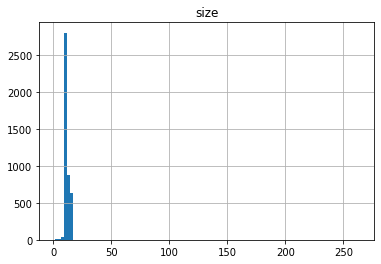

In [13]:
checdf.hist(column='size', bins=100)

In [14]:
checdf['yid'] = checdf.yid.apply(lambda x: x.replace('.aac', '.wav'))

## Audio to Spectrogram

* Thanks to etown for the spectogram code - https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb

In [15]:
wavdata = Path(audio_data_path)
# pngdata = Path('./data/google_audioset/google_audioset_BM_10spng/')
pngdata = Path(image_data_path)
if pngdata.exists()==False:
    pngdata.mkdir()

In [19]:
# Code taken directly from https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb with minimal changes 
def spectrogram(wavfile):
    #print(wavfile)
    fpath = wavdata/wavfile
    X,sr = librosa.load(fpath)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    Pxx, freqs, bins, im = plt.specgram(np.array(X), Fs=22050)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
#     plt.show()
    filename  = pngdata/wavfile.replace('.wav','.png')
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close('all')
    gc.collect() 
#     break

In [20]:
import multiprocessing as mp
with mp.Pool(7) as pool:
    list(tqdm(pool.imap(spectrogram, checdf['yid'].values), total=checdf.shape[0]))

  0%|          | 0/4391 [00:00<?, ?it/s]/home/sramirez/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
  0%|          | 1/4391 [00:01<2:00:15,  1.64s/it]/home/sramirez/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
  0%|          | 5/4391 [00:01<1:25:25,  1.17s/it]/home/sramirez/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/home/sramirez/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/home/sramirez/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
  0%|          | 11/4391 [00:02<45:57,  1.59it/s] /home/sram

KeyboardInterrupt: 

## Creating the labels.csv file based on the dataset generated above

In [59]:
metadata = pd.read_csv('../data/interim/firewind_dataset_links.csv')
metadata.shape

(18082, 11)

In [69]:
files = os.listdir(image_data_path)
result = map(lambda x: x.split('.')[0], files)
saved_id = list(result)
subset = set(metadata['# YTID']).intersection(set(saved_id))
len(subset) # all are present

4391

In [77]:
label_df = metadata[metadata['# YTID'].isin(subset)]
label_df.translated_labels.value_counts()

Wind                  1040
Thunderstorm          1008
Water                  974
Fire                   971
Fire,Wind              356
Wind,Thunderstorm       27
Wind,Water               8
Fire,Water               5
Water,Thunderstorm       2
Name: translated_labels, dtype: int64

In [78]:
label_df = label_df[['# YTID', 'Fire']]
label_df.columns = ['id', 'label']
label_df.head()

,id,label
17,0o4vHYlTPBA,0
18,0ogrLUe_WSY,0
19,0rcgzQpsWYs,1
21,11-d3rWQxZY,1
26,1OM5619KGEI,0


In [79]:
label_df.label.value_counts()

0    3059
1    1332
Name: label, dtype: int64

In [80]:
label_df.to_csv('../data/label_audioset.csv')